# Import Libraries

In [12]:
import json
import graphviz 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import Counter
from scipy.stats import kurtosis

from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.feature_selection import mutual_info_classif
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, roc_auc_score, homogeneity_score, silhouette_score, completeness_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

%matplotlib inline

# Load data

In [13]:
df = pd.read_csv('Telco-Customer-Churn.csv')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [14]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

# Data Exploration

### Look for missing values

In [15]:
# Missing values
(df.count() - df.count().max()).abs()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Check values to make sure they make sense

In [16]:
# All potential categorical values
categories = {}
for col in df:
    if df[col].dtype == object and col != 'customerID':
        categories[col] = list(df[col].unique())

print(json.dumps(categories, indent=2))

{
  "gender": [
    "Female",
    "Male"
  ],
  "Partner": [
    "Yes",
    "No"
  ],
  "Dependents": [
    "No",
    "Yes"
  ],
  "PhoneService": [
    "No",
    "Yes"
  ],
  "MultipleLines": [
    "No phone service",
    "No",
    "Yes"
  ],
  "InternetService": [
    "DSL",
    "Fiber optic",
    "No"
  ],
  "OnlineSecurity": [
    "No",
    "Yes",
    "No internet service"
  ],
  "OnlineBackup": [
    "Yes",
    "No",
    "No internet service"
  ],
  "DeviceProtection": [
    "No",
    "Yes",
    "No internet service"
  ],
  "TechSupport": [
    "No",
    "Yes",
    "No internet service"
  ],
  "StreamingTV": [
    "No",
    "Yes",
    "No internet service"
  ],
  "StreamingMovies": [
    "No",
    "Yes",
    "No internet service"
  ],
  "Contract": [
    "Month-to-month",
    "One year",
    "Two year"
  ],
  "PaperlessBilling": [
    "Yes",
    "No"
  ],
  "PaymentMethod": [
    "Electronic check",
    "Mailed check",
    "Bank transfer (automatic)",
    "Credit card (automatic)"

In [17]:
# Numerical values
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


### Correlation analysis

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.016567,0.220173,0.103006
tenure,0.016567,1.000000,0.247900,0.826178
MonthlyCharges,0.220173,0.247900,1.000000,0.651174
TotalCharges,0.103006,0.826178,0.651174,1.000000


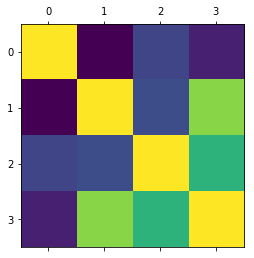

In [18]:
plt.matshow(df.corr())
df.corr()

# Check for target balance

In [96]:
print(1869.0 / X.shape[0])
df[['Churn', 'Contract']].groupby('Churn').count()

0.2653698707936959


,Contract
Churn,
No,5174
Yes,1869


# Create datasets

In [21]:
RANDOM_STATE = 25

# Create one-hot encodings of categorical variables
categorical_columns = [x for x in categories.keys() if x != 'Churn']
X = pd.get_dummies(df, columns=categorical_columns)
X_df = X

# Get y labels as 1 or 0
y = np.where(X['Churn'] == 'Yes', 1, 0)
X.drop(columns=['customerID', "Churn"], inplace=True)
cols = X.columns

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Split dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

### Helper functions

In [23]:
def plot_curves(title, xlabel, ylabel, train_set, test_set, metric_label, ylim_min=0.75):
    plt.plot(train_set, linewidth=3, label='Training ' + metric_label)
    plt.plot(test_set, linewidth=3, label='Test ' + metric_label)
    plt.legend()
    plt.title(title)
    plt.ylim(ylim_min, 1.0)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.figure(figsize=(12,12))
    plt.show()
    
def learning_curve(clf_name, clf, step=5):
    train_auc, test_auc = [], []
    x_step = []
    for i in range(step, 101, step):
        pct = 1.0 * i / 100
        upper = int(X_train.shape[0] * pct) - 1
        X_train_sub = X_train[:upper]
        y_train_sub = y_train[:upper]
        x_step.append(upper)
        
        clf = clf.fit(X_train_sub, y_train_sub)
        train_auc.append(roc_auc_score(y_train_sub, clf.predict_proba(X_train_sub)[:,1]))
        test_auc.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
        
    plt.plot(np.array(x_step), np.array(train_auc), label='Training AUC')
    plt.plot(np.array(x_step), np.array(test_auc), label='Test AUC')
    plt.legend()
    plt.title('Bank ' + clf_name + ' Learning Curves')
    plt.ylim(0.50, 1.0)
    plt.xlabel('# of Samples')
    plt.ylabel('ROC AUC')
    plt.figure(figsize=(12,12))
    plt.show()

def plot_curve(title, xlabel, ylabel, x, y):
    plt.plot(np.array(x), np.array(y))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.figure(figsize=(12,12))
    plt.show()

# K-Means

### Model Complexity Curves

In [24]:
max_k = 112
x = []
inertia_scores = []
silhouette_scores = []
completeness_scores = []
homogeneity_scores = []

for i in range(2, max_k + 1, 5):
    x.append(i)
    print(i)
    
    clf = MiniBatchKMeans(n_clusters=i, random_state=RANDOM_STATE)
    clf = clf.fit(X)
    
    inertia_scores.append(clf.inertia_)
    silhouette_scores.append(silhouette_score(X, clf.labels_))
    completeness_scores.append(completeness_score(y, clf.labels_))
    homogeneity_scores.append(homogeneity_score(y, clf.labels_))

2
7
12
17
22
27
32
37
42
47
52
57
62
67
72
77
82
87
92
97
102
107
112


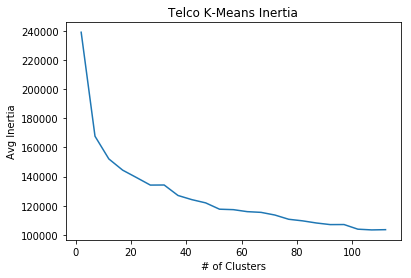

<Figure size 864x864 with 0 Axes>

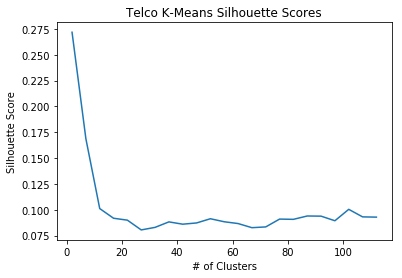

<Figure size 864x864 with 0 Axes>

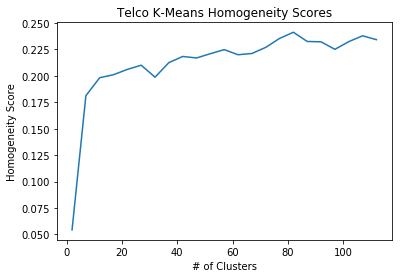

<Figure size 864x864 with 0 Axes>

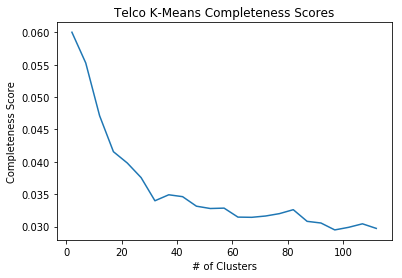

<Figure size 864x864 with 0 Axes>

In [25]:
plot_curve('Telco K-Means Inertia', '# of Clusters', 'Avg Inertia', x, inertia_scores)
plot_curve('Telco K-Means Silhouette Scores', '# of Clusters', 'Silhouette Score', x, silhouette_scores)
plot_curve('Telco K-Means Homogeneity Scores', '# of Clusters', 'Homogeneity Score', x, homogeneity_scores)
plot_curve('Telco K-Means Completeness Scores', '# of Clusters', 'Completeness Score', x, completeness_scores)

# Expectation Minimization

In [26]:
max_k = 112
gmm_x = []
gmm_log_likelihood = []
gmm_silhouette_scores = []
gmm_completeness_scores = []
gmm_homogeneity_scores = []
gmm_aic_scores = []
gmm_bic_scores = []

for i in range(2, max_k + 1, 5):
    gmm_x.append(i)
    print(i)
    
    clf = GaussianMixture(n_components=i, random_state=RANDOM_STATE)
    clf = clf.fit(X)
    labels = clf.predict(X)
    
    
    gmm_log_likelihood.append(clf.score(X))
    gmm_silhouette_scores.append(silhouette_score(X, labels))
    gmm_completeness_scores.append(completeness_score(y, labels))
    gmm_homogeneity_scores.append(homogeneity_score(y, labels))
    gmm_aic_scores.append(clf.aic(X))
    gmm_bic_scores.append(clf.bic(X))

2
7
12
17
22
27
32
37
42
47
52
57
62
67
72
77
82
87
92
97
102
107
112


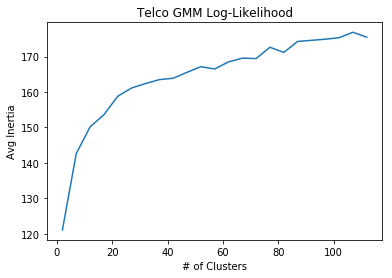

<Figure size 864x864 with 0 Axes>

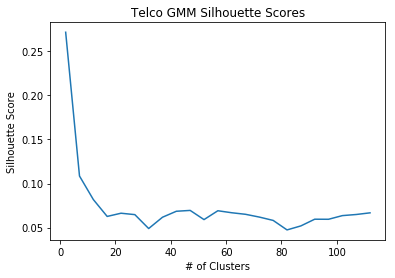

<Figure size 864x864 with 0 Axes>

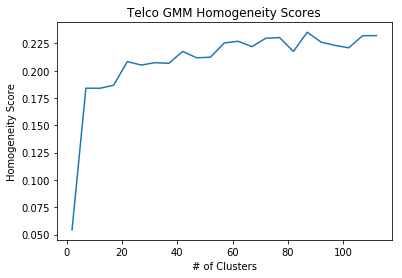

<Figure size 864x864 with 0 Axes>

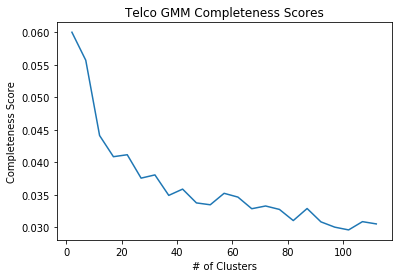

<Figure size 864x864 with 0 Axes>

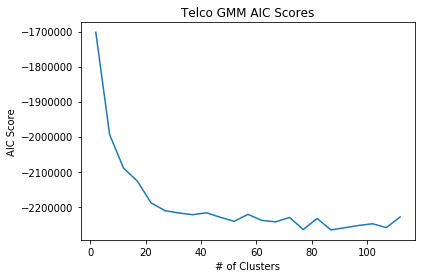

<Figure size 864x864 with 0 Axes>

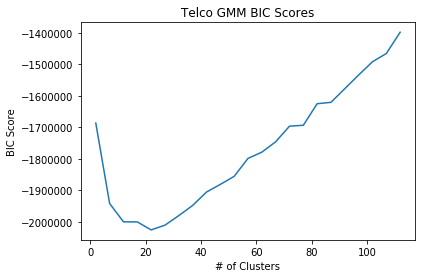

<Figure size 864x864 with 0 Axes>

In [31]:
plot_curve('Telco GMM Log-Likelihood', '# of Clusters', 'Avg Inertia', gmm_x, gmm_log_likelihood)
plot_curve('Telco GMM Silhouette Scores', '# of Clusters', 'Silhouette Score', gmm_x, gmm_silhouette_scores)
plot_curve('Telco GMM Homogeneity Scores', '# of Clusters', 'Homogeneity Score', gmm_x, gmm_homogeneity_scores)
plot_curve('Telco GMM Completeness Scores', '# of Clusters', 'Completeness Score', gmm_x, gmm_completeness_scores)
plot_curve('Telco GMM AIC Scores', '# of Clusters', 'AIC Score', gmm_x, gmm_aic_scores)
plot_curve('Telco GMM BIC Scores', '# of Clusters', 'BIC Score', gmm_x, gmm_bic_scores)

### Making sense out of the clusters

In [32]:
clf = MiniBatchKMeans(n_clusters=18, random_state=RANDOM_STATE)
clf = clf.fit(X)
X_df['K-means clusters'] = clf.labels_

clf = GaussianMixture(n_components=18, random_state=RANDOM_STATE)
clf = clf.fit(X)
X_df['GMM clusters'] = clf.predict(X)

In [39]:
X_df.groupby('K-means clusters').mean().std() / X_df.groupby('K-means clusters').mean().mean()

SeniorCitizen                              1.093862
tenure                                     0.545020
MonthlyCharges                             0.505245
TotalCharges                               0.898777
gender_Female                              0.333398
gender_Male                                0.304355
Partner_No                                 0.691314
Partner_Yes                                0.584014
Dependents_No                              0.522219
Dependents_Yes                             0.921324
PhoneService_No                            2.910428
PhoneService_Yes                           0.363803
MultipleLines_No                           0.652141
MultipleLines_No phone service             2.910428
MultipleLines_Yes                          0.725953
InternetService_DSL                        1.256821
InternetService_Fiber optic                1.127369
InternetService_No                         1.659199
OnlineSecurity_No                          0.846440
OnlineSecuri

### Helper methods for dimensionality reduction data set accuracy analysis

In [40]:
def plot_dim_reduction_acc(x_range, dim_redux, cross_val_acc, title, xlabel, ylabel, dim_redux_label):    
    fig, ax1 = plt.subplots()

    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(dim_redux_label)
    ax1.bar(x_range, dim_redux, color='cyan')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('Cross-Validation Accuracy')  # we already handled the x-label with ax1
    ax2.plot(x_range, cross_val_acc, color='blue')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(title)
    plt.show()


def plot_nn_acc(x_range, train_acc, test_acc, title, xlabel):
    plt.plot(x_range, train_acc, linewidth=3, label='Training Accuracy')
    plt.plot(x_range, test_acc, linewidth=3, label='Test Accuracy')
    plt.legend()
    plt.title(title)
    plt.ylim(0.3, 1.0)
    plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.figure(figsize=(12,12))
    plt.show()

# PCA Analysis

In [42]:
num_components = 45
pca = PCA(n_components=num_components)
pca = pca.fit(X)

### Accuracy analysis - optimum # of components

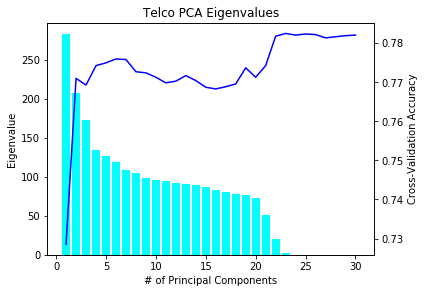

In [49]:
X_dim_redux = pca.transform(X)
max_eigenvalues = 30

cross_val_acc = []
x_range = []
for i in range(1, max_eigenvalues + 1):
    x_range.append(i)
    X_sub = X_dim_redux[:, 0:i]
    clf = DecisionTreeClassifier(max_depth=6, criterion='gini')
    score = cross_val_score(clf, X_sub, y, cv=5).mean()
    cross_val_acc.append(score)

plot_dim_reduction_acc(x_range, pca.singular_values_[:max_eigenvalues], cross_val_acc, 'Telco PCA Eigenvalues', '# of Principal Components',
                       'Eigenvalue', 'Eigenvalue')

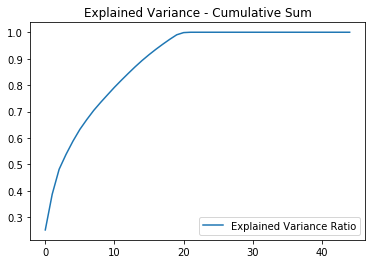

In [50]:
pca_explained_variance = pd.DataFrame(pca.explained_variance_ratio_, columns=['Explained Variance Ratio'])
pca_explained_variance.cumsum().plot(title='Explained Variance - Cumulative Sum')

### K-Means on PCA

In [51]:
X_pca = pca.transform(X)[:, 0:6]

max_k = 112
pca_x = []
pca_inertia_scores = []
pca_silhouette_scores = []
pca_completeness_scores = []
pca_homogeneity_scores = []

for i in range(2, max_k + 1, 5):
    pca_x.append(i)    
    clf = MiniBatchKMeans(n_clusters=i, random_state=RANDOM_STATE)
    clf = clf.fit(X_pca)
    
    pca_inertia_scores.append(clf.inertia_)
    pca_silhouette_scores.append(silhouette_score(X, clf.labels_))
    pca_completeness_scores.append(completeness_score(y, clf.labels_))
    pca_homogeneity_scores.append(homogeneity_score(y, clf.labels_))

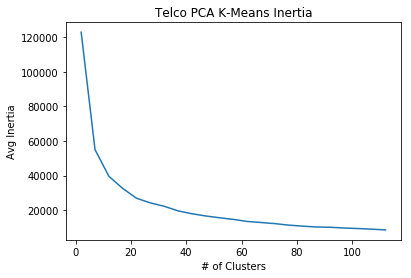

<Figure size 864x864 with 0 Axes>

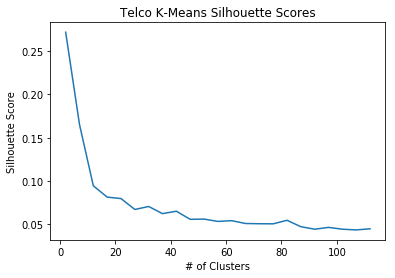

<Figure size 864x864 with 0 Axes>

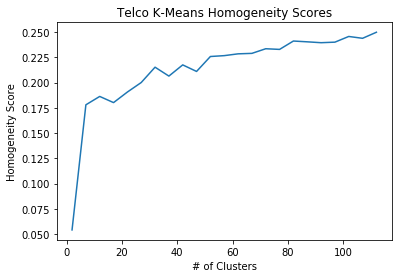

<Figure size 864x864 with 0 Axes>

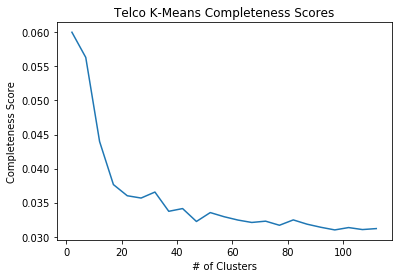

<Figure size 864x864 with 0 Axes>

In [52]:
plot_curve('Telco PCA K-Means Inertia', '# of Clusters', 'Avg Inertia', pca_x, pca_inertia_scores)
plot_curve('Telco K-Means Silhouette Scores', '# of Clusters', 'Silhouette Score', pca_x, pca_silhouette_scores)
plot_curve('Telco K-Means Homogeneity Scores', '# of Clusters', 'Homogeneity Score', pca_x, pca_homogeneity_scores)
plot_curve('Telco K-Means Completeness Scores', '# of Clusters', 'Completeness Score', pca_x, pca_completeness_scores)

In [53]:
X_pca = pca.transform(X)[:, 0:5]

max_k = 112
pca_gmm_x = []
pca_gmm_log_likelihood = []
pca_gmm_silhouette_scores = []
pca_gmm_completeness_scores = []
pca_gmm_homogeneity_scores = []
pca_gmm_aic_scores = []
pca_gmm_bic_scores = []

for i in range(2, max_k + 1, 5):
    pca_gmm_x.append(i)
    print(i)
    
    clf = GaussianMixture(n_components=i, random_state=RANDOM_STATE)
    clf = clf.fit(X_pca)
    labels = clf.predict(X_pca)
    
    pca_gmm_log_likelihood.append(clf.score(X_pca))
    pca_gmm_silhouette_scores.append(silhouette_score(X_pca, labels))
    pca_gmm_completeness_scores.append(completeness_score(y, labels))
    pca_gmm_homogeneity_scores.append(homogeneity_score(y, labels))
    pca_gmm_aic_scores.append(clf.aic(X_pca))
    pca_gmm_bic_scores.append(clf.bic(X_pca))

2
7
12
17
22
27
32
37
42
47
52
57
62
67
72
77
82
87
92
97
102
107
112


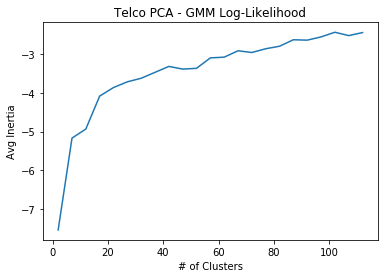

<Figure size 864x864 with 0 Axes>

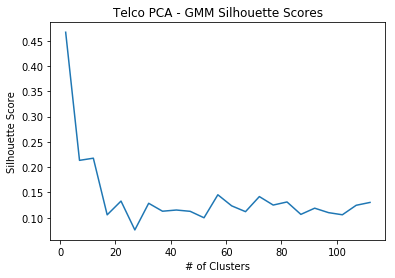

<Figure size 864x864 with 0 Axes>

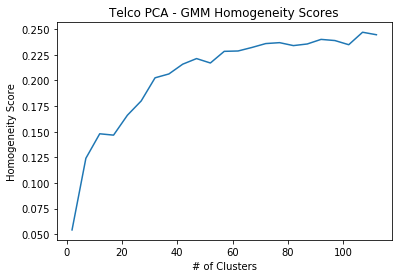

<Figure size 864x864 with 0 Axes>

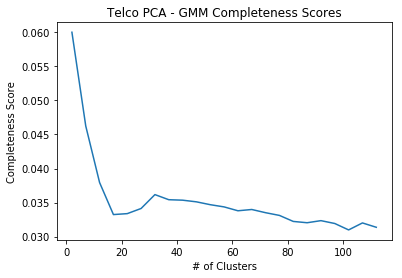

<Figure size 864x864 with 0 Axes>

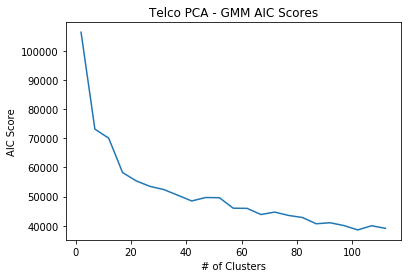

<Figure size 864x864 with 0 Axes>

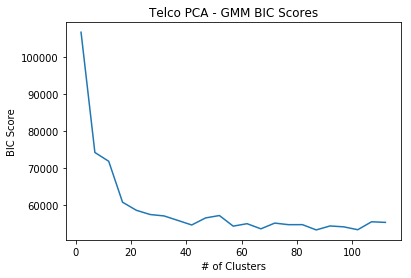

<Figure size 864x864 with 0 Axes>

In [54]:
plot_curve('Telco PCA - GMM Log-Likelihood', '# of Clusters', 'Avg Inertia', pca_gmm_x, pca_gmm_log_likelihood)
plot_curve('Telco PCA - GMM Silhouette Scores', '# of Clusters', 'Silhouette Score', pca_gmm_x, pca_gmm_silhouette_scores)
plot_curve('Telco PCA - GMM Homogeneity Scores', '# of Clusters', 'Homogeneity Score', pca_gmm_x, pca_gmm_homogeneity_scores)
plot_curve('Telco PCA - GMM Completeness Scores', '# of Clusters', 'Completeness Score', pca_gmm_x, pca_gmm_completeness_scores)
plot_curve('Telco PCA - GMM AIC Scores', '# of Clusters', 'AIC Score', pca_gmm_x, pca_gmm_aic_scores)
plot_curve('Telco PCA - GMM BIC Scores', '# of Clusters', 'BIC Score', pca_gmm_x, pca_gmm_bic_scores)

### Neural Network Performance

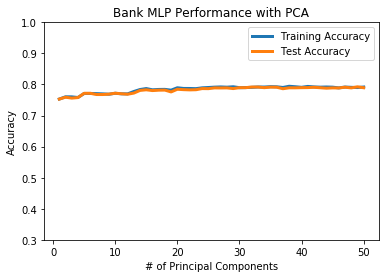

<Figure size 864x864 with 0 Axes>

In [59]:
X_pca = pca.transform(X)
max_eigenvalues = X_pca.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=RANDOM_STATE)

train_acc = []
test_acc = []
x_range = []
for i in range(1, max_eigenvalues + 1):
    x_range.append(i)
    X_train_sub = X_train[:, 0:i]
    X_test_sub = X_test[:, 0:i]
    clf = MLPClassifier(solver='adam', alpha=1.0, activation='relu', batch_size=20,
                learning_rate='constant', random_state=RANDOM_STATE,
                hidden_layer_sizes=(30), max_iter=10)
    clf = clf.fit(X_train_sub, y_train)

    train_acc.append(accuracy_score(y_train, clf.predict(X_train_sub)))
    test_acc.append(accuracy_score(y_test, clf.predict(X_test_sub)))

plot_nn_acc(x_range, train_acc, test_acc, 'Bank MLP Performance with PCA', '# of Principal Components')

# ICA Analysis

In [55]:
num_components = 50
ica = FastICA(n_components=num_components, random_state=RANDOM_STATE)
ica = ica.fit(X)

/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:301: UserWarning: n_components is too large: it will be set to 45
  warnings.warn('n_components is too large: it will be set to %s' % n_components)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/scipy/linalg/basic.py:1321: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  x, resids, rank, s = lstsq(a, b, cond=cond, check_finite=False)


### Accuracy analysis - optimum # of components

In [67]:
ica_kurtosis = ica_df.kurt(axis=0).as_matrix()
kurt_indexes = ica_kurtosis.argsort()
X_ica[:, kurt_indexes[0:4]].shape

/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


(7043, 4)

/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


10
20
30
40


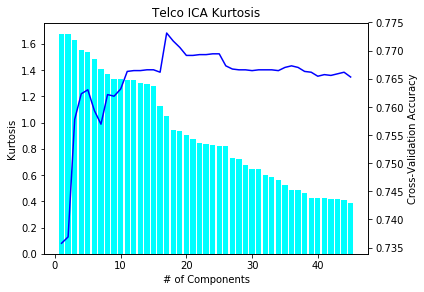

In [73]:
max_components = X.shape[1]
ica = FastICA(n_components=X.shape[1], random_state=RANDOM_STATE, max_iter=500)
ica = ica.fit(X)
X_ica = ica.transform(X)

ica_df = pd.DataFrame(X_ica)
ica_kurtosis = np.absolute(ica_df.kurt(axis=0).as_matrix())
kurt_indexes = ica_kurtosis.argsort()[::-1]

kurt = []
cross_val_acc = []
x_range = []
for i in range(1, max_components + 1):
    if i % 10 == 0:
        print(i)
    
    x_range.append(i)
    X_sub = X_ica[:, kurt_indexes[0:i]]
    
    # Cross-validation accuracy
    clf = DecisionTreeClassifier(max_depth=5, criterion='gini')
    score = cross_val_score(clf, X_sub, y, cv=5).mean()
    cross_val_acc.append(score)

plot_dim_reduction_acc(x_range, ica_kurtosis[kurt_indexes], cross_val_acc, 'Telco ICA Kurtosis', '# of Components',
                       'Kurtosis', 'Kurtosis')

### K-Means on ICA

In [80]:
max_k = 112
ica_x = []
ica_inertia_scores = []
ica_silhouette_scores = []
ica_completeness_scores = []
ica_homogeneity_scores = []
X_ica_cluster = X_ica[:, kurt_indexes[0:17]]

for i in range(2, max_k + 1, 5):
    ica_x.append(i)
    clf = MiniBatchKMeans(n_clusters=i, random_state=RANDOM_STATE)
    clf = clf.fit(X_ica_cluster)
    
    ica_inertia_scores.append(clf.inertia_)
    ica_silhouette_scores.append(silhouette_score(X_ica_cluster, clf.labels_))
    ica_completeness_scores.append(completeness_score(y, clf.labels_))
    ica_homogeneity_scores.append(homogeneity_score(y, clf.labels_))

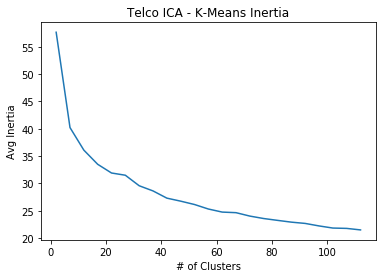

<Figure size 864x864 with 0 Axes>

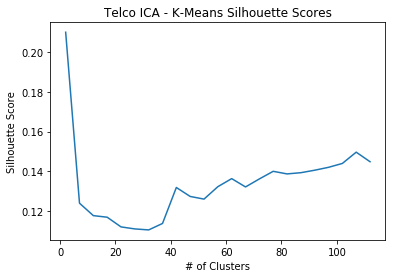

<Figure size 864x864 with 0 Axes>

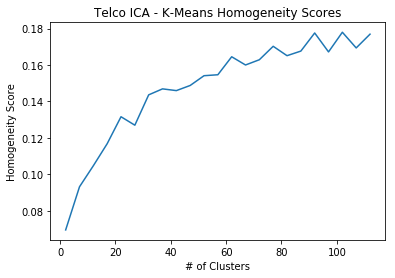

<Figure size 864x864 with 0 Axes>

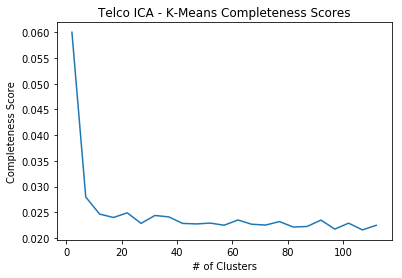

<Figure size 864x864 with 0 Axes>

In [81]:
plot_curve('Telco ICA - K-Means Inertia', '# of Clusters', 'Avg Inertia', ica_x, ica_inertia_scores)
plot_curve('Telco ICA - K-Means Silhouette Scores', '# of Clusters', 'Silhouette Score', ica_x, ica_silhouette_scores)
plot_curve('Telco ICA - K-Means Homogeneity Scores', '# of Clusters', 'Homogeneity Score', ica_x, ica_homogeneity_scores)
plot_curve('Telco ICA - K-Means Completeness Scores', '# of Clusters', 'Completeness Score', ica_x, ica_completeness_scores)

### GMM on ICA

In [82]:
max_k = 112
ica_gmm_x = []
ica_gmm_log_likelihood = []
ica_gmm_silhouette_scores = []
ica_gmm_completeness_scores = []
ica_gmm_homogeneity_scores = []
ica_gmm_aic_scores = []
ica_gmm_bic_scores = []

for i in range(2, max_k + 1, 5):
    ica_gmm_x.append(i)
    print(i)
    
    clf = GaussianMixture(n_components=i, random_state=RANDOM_STATE)
    clf = clf.fit(X_ica_cluster)
    labels = clf.predict(X_ica_cluster)
    
    ica_gmm_log_likelihood.append(clf.score(X_ica_cluster))
    ica_gmm_silhouette_scores.append(silhouette_score(X_ica_cluster, labels))
    ica_gmm_completeness_scores.append(completeness_score(y, labels))
    ica_gmm_homogeneity_scores.append(homogeneity_score(y, labels))
    ica_gmm_aic_scores.append(clf.aic(X_ica_cluster))
    ica_gmm_bic_scores.append(clf.bic(X_ica_cluster))

2
7
12
17
22
27
32
37
42
47
52
57
62
67
72
77
82
87
92
97
102
107
112


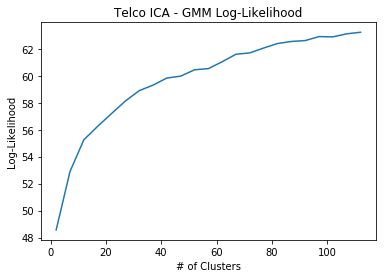

<Figure size 864x864 with 0 Axes>

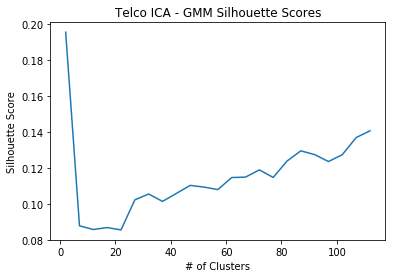

<Figure size 864x864 with 0 Axes>

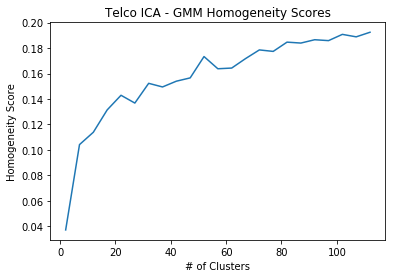

<Figure size 864x864 with 0 Axes>

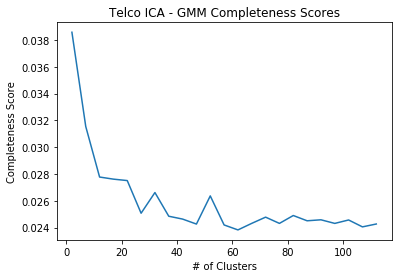

<Figure size 864x864 with 0 Axes>

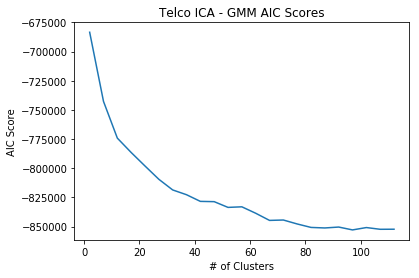

<Figure size 864x864 with 0 Axes>

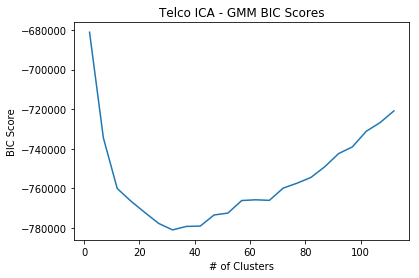

<Figure size 864x864 with 0 Axes>

In [84]:
plot_curve('Telco ICA - GMM Log-Likelihood', '# of Clusters', 'Log-Likelihood', ica_gmm_x, ica_gmm_log_likelihood)
plot_curve('Telco ICA - GMM Silhouette Scores', '# of Clusters', 'Silhouette Score', ica_gmm_x, ica_gmm_silhouette_scores)
plot_curve('Telco ICA - GMM Homogeneity Scores', '# of Clusters', 'Homogeneity Score', ica_gmm_x, ica_gmm_homogeneity_scores)
plot_curve('Telco ICA - GMM Completeness Scores', '# of Clusters', 'Completeness Score', ica_gmm_x, ica_gmm_completeness_scores)
plot_curve('Telco ICA - GMM AIC Scores', '# of Clusters', 'AIC Score', ica_gmm_x, ica_gmm_aic_scores)
plot_curve('Telco ICA - GMM BIC Scores', '# of Clusters', 'BIC Score', ica_gmm_x, ica_gmm_bic_scores)

# Randomized Projections

In [90]:
num_components = 100
grp = GaussianRandomProjection(n_components=num_components, random_state=RANDOM_STATE)
grp = grp.fit(X)

### Accuracy analysis - optimum # of components

1
2
3
4
5


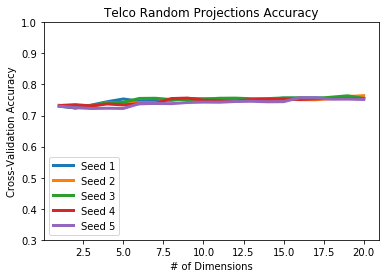

<Figure size 864x864 with 0 Axes>

In [95]:
X_rand = grp.transform(X)
max_components = X_rand.shape[1]

for j in range(1, 6):
    print(j)
    num_components = 20
    grp = GaussianRandomProjection(n_components=num_components, random_state=j)
    grp = grp.fit(X)
    X_rand = grp.transform(X)
    
    cross_val_acc = []
    x_range = []
    for i in range(1, num_components + 1, 1):
        x_range.append(i)
        X_sub = X_rand[:, 0:i]
        clf = DecisionTreeClassifier(max_depth=6, criterion='gini')
        score = cross_val_score(clf, X_sub, y, cv=5).mean()
        cross_val_acc.append(score)

    plt.plot(x_range, cross_val_acc, linewidth=3, label='Seed %d' % j)

plt.title('Telco Random Projections Accuracy')
plt.legend()
plt.ylim(0.3, 1.0)
plt.xlabel('# of Dimensions')
plt.ylabel('Cross-Validation Accuracy')
plt.figure(figsize=(12,12))
plt.show()

### K-Means on Randomized Projections

In [97]:
X_rand = grp.transform(X)[:, 0:15]

max_k = 112
rand_x = []
rand_inertia_scores = []
rand_silhouette_scores = []
rand_completeness_scores = []
rand_homogeneity_scores = []

for i in range(2, max_k + 1, 5):
    rand_x.append(i)    
    clf = MiniBatchKMeans(n_clusters=i, random_state=RANDOM_STATE)
    clf = clf.fit(X_rand)
    
    rand_inertia_scores.append(clf.inertia_)
    rand_silhouette_scores.append(silhouette_score(X, clf.labels_))
    rand_completeness_scores.append(completeness_score(y, clf.labels_))
    rand_homogeneity_scores.append(homogeneity_score(y, clf.labels_))

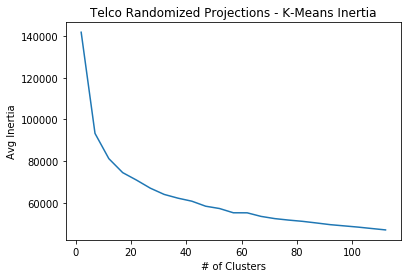

<Figure size 864x864 with 0 Axes>

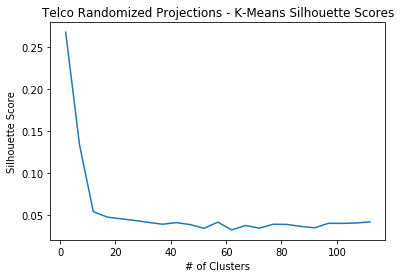

<Figure size 864x864 with 0 Axes>

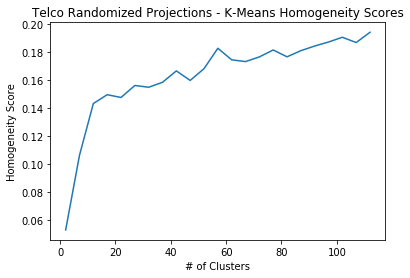

<Figure size 864x864 with 0 Axes>

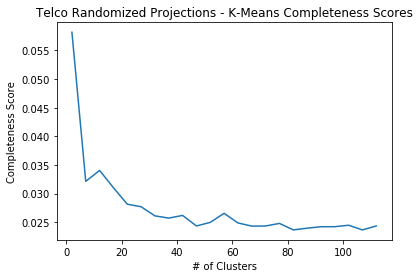

<Figure size 864x864 with 0 Axes>

In [98]:
plot_curve('Telco Randomized Projections - K-Means Inertia', '# of Clusters', 'Avg Inertia', x, rand_inertia_scores)
plot_curve('Telco Randomized Projections - K-Means Silhouette Scores', '# of Clusters', 'Silhouette Score', x, rand_silhouette_scores)
plot_curve('Telco Randomized Projections - K-Means Homogeneity Scores', '# of Clusters', 'Homogeneity Score', x, rand_homogeneity_scores)
plot_curve('Telco Randomized Projections - K-Means Completeness Scores', '# of Clusters', 'Completeness Score', x, rand_completeness_scores)

### GMM on Randomized Projections

In [99]:
X_rand = grp.transform(X)[:, 0:15]

max_k = 112
rand_gmm_x = []
rand_gmm_log_likelihood = []
rand_gmm_silhouette_scores = []
rand_gmm_completeness_scores = []
rand_gmm_homogeneity_scores = []
rand_gmm_aic_scores = []
rand_gmm_bic_scores = []

for i in range(2, max_k + 1, 5):
    rand_gmm_x.append(i)
    print(i)
    
    clf = GaussianMixture(n_components=i, random_state=RANDOM_STATE)
    clf = clf.fit(X_rand)
    labels = clf.predict(X_rand)
    
    
    rand_gmm_log_likelihood.append(clf.score(X_rand))
    rand_gmm_silhouette_scores.append(silhouette_score(X_rand, labels))
    rand_gmm_completeness_scores.append(completeness_score(y, labels))
    rand_gmm_homogeneity_scores.append(homogeneity_score(y, labels))
    rand_gmm_aic_scores.append(clf.aic(X_rand))
    rand_gmm_bic_scores.append(clf.bic(X_rand))

2
7
12
17
22
27
32
37
42
47
52
57
62
67
72
77
82
87
92
97
102
107
112


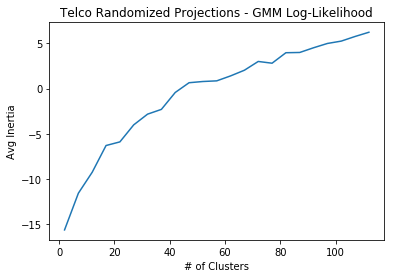

<Figure size 864x864 with 0 Axes>

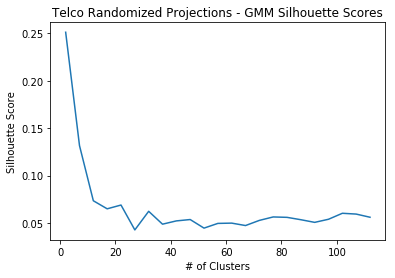

<Figure size 864x864 with 0 Axes>

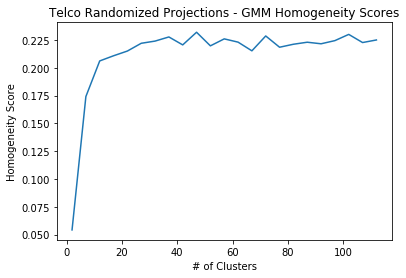

<Figure size 864x864 with 0 Axes>

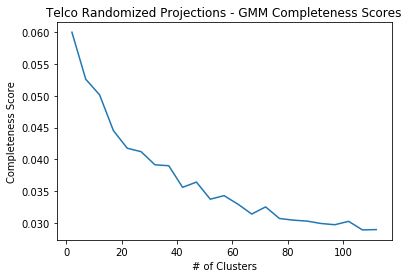

<Figure size 864x864 with 0 Axes>

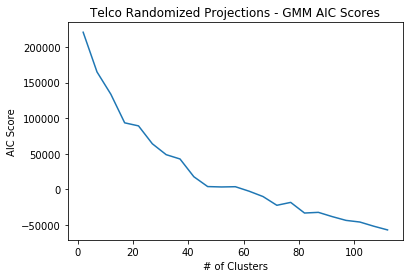

<Figure size 864x864 with 0 Axes>

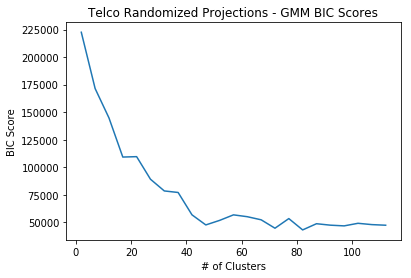

<Figure size 864x864 with 0 Axes>

In [100]:
plot_curve('Telco Randomized Projections - GMM Log-Likelihood', '# of Clusters', 'Avg Inertia', rand_gmm_x, rand_gmm_log_likelihood)
plot_curve('Telco Randomized Projections - GMM Silhouette Scores', '# of Clusters', 'Silhouette Score', rand_gmm_x, rand_gmm_silhouette_scores)
plot_curve('Telco Randomized Projections - GMM Homogeneity Scores', '# of Clusters', 'Homogeneity Score', rand_gmm_x, rand_gmm_homogeneity_scores)
plot_curve('Telco Randomized Projections - GMM Completeness Scores', '# of Clusters', 'Completeness Score', rand_gmm_x, rand_gmm_completeness_scores)
plot_curve('Telco Randomized Projections - GMM AIC Scores', '# of Clusters', 'AIC Score', rand_gmm_x, rand_gmm_aic_scores)
plot_curve('Telco Randomized Projections - GMM BIC Scores', '# of Clusters', 'BIC Score', rand_gmm_x, rand_gmm_bic_scores)

# Feature Selection - Filtering

In [101]:
# http://datascience.stackexchange.com/questions/6683/feature-selection-using-feature-importances-in-random-forests-with-scikit-learn          
class ImportanceSelector(BaseEstimator, TransformerMixin):
    def __init__(self, model, n=1):
         self.model = model
         self.n = n
    def fit(self, *args, **kwargs):
         self.model.fit(*args, **kwargs)
         return self
    def transform(self, X):
         return X[:,self.model.feature_importances_.argsort()[::-1][:self.n]]

rfc = RandomForestClassifier(max_depth=4, n_estimators=20)
feature_selector = ImportanceSelector(rfc, n=20)
feature_selector = feature_selector.fit(X, y)

### Accuracy analysis - optimum # of components

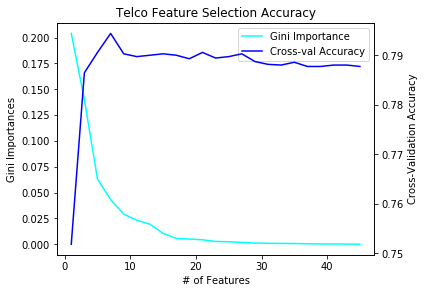

In [107]:
max_components = X.shape[1]

cross_val_acc = []
feature_importances = []
x_range = []
for i in range(1, max_components + 1, 2):
    feature_selector = ImportanceSelector(rfc, n=i)
    feature_selector = feature_selector.fit(X, y)
    X_fselect = feature_selector.transform(X)
    
    x_range.append(i)
    X_sub = X_fselect[:, 0:i]
    clf = DecisionTreeClassifier(max_depth=6, criterion='gini')
    score = cross_val_score(clf, X_sub, y, cv=5).mean()
    cross_val_acc.append(score)

# gini importances
temp_importances = np.array(feature_selector.model.feature_importances_)
temp_importances.sort()
sorted_importances = np.flip(temp_importances)
importances_to_chart = sorted_importances[[i - 1 for i in range(1, max_components + 1, 2)]]
    
fig, ax1 = plt.subplots()

ax1.set_xlabel('# of Features')
ax1.set_ylabel('Gini Importances')
ln1 = ax1.plot(x_range, importances_to_chart, color='cyan', label='Gini Importance')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Cross-Validation Accuracy')  # we already handled the x-label with ax1
ln2 = ax2.plot(x_range, cross_val_acc, color='blue', label='Cross-val Accuracy')

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=1)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Telco Feature Selection Accuracy')
plt.show()
    


### K-Means on Feature Selection

In [108]:
rfc = RandomForestClassifier(max_depth=4, n_estimators=20)
feature_selector = ImportanceSelector(rfc, n=10)
feature_selector = feature_selector.fit(X, y)
X_fs = feature_selector.transform(X)

max_k = 112
fs_x = []
fs_inertia_scores = []
fs_silhouette_scores = []
fs_completeness_scores = []
fs_homogeneity_scores = []

for i in range(2, max_k + 1, 5):
    fs_x.append(i)    
    clf = MiniBatchKMeans(n_clusters=i, random_state=RANDOM_STATE)
    clf = clf.fit(X_fs)
    
    fs_inertia_scores.append(clf.inertia_)
    fs_silhouette_scores.append(silhouette_score(X, clf.labels_))
    fs_completeness_scores.append(completeness_score(y, clf.labels_))
    fs_homogeneity_scores.append(homogeneity_score(y, clf.labels_))

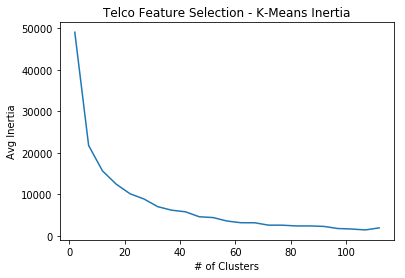

<Figure size 864x864 with 0 Axes>

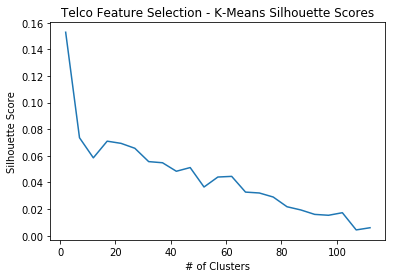

<Figure size 864x864 with 0 Axes>

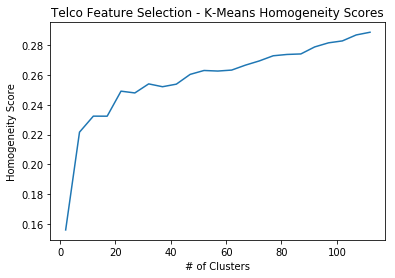

<Figure size 864x864 with 0 Axes>

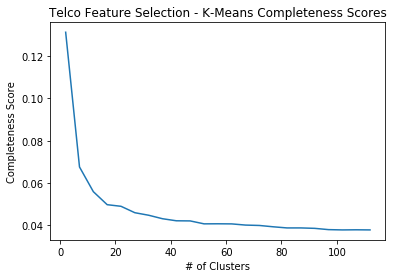

<Figure size 864x864 with 0 Axes>

In [109]:
plot_curve('Telco Feature Selection - K-Means Inertia', '# of Clusters', 'Avg Inertia', x, fs_inertia_scores)
plot_curve('Telco Feature Selection - K-Means Silhouette Scores', '# of Clusters', 'Silhouette Score', x, fs_silhouette_scores)
plot_curve('Telco Feature Selection - K-Means Homogeneity Scores', '# of Clusters', 'Homogeneity Score', x, fs_homogeneity_scores)
plot_curve('Telco Feature Selection - K-Means Completeness Scores', '# of Clusters', 'Completeness Score', x, fs_completeness_scores)

### GMM on Feature Selection

In [110]:
rfc = RandomForestClassifier(max_depth=4, n_estimators=20)
feature_selector = ImportanceSelector(rfc, n=10)
feature_selector = feature_selector.fit(X, y)
X_fs = feature_selector.transform(X)

max_k = 112
fs_gmm_x = []
fs_gmm_log_likelihood = []
fs_gmm_silhouette_scores = []
fs_gmm_completeness_scores = []
fs_gmm_homogeneity_scores = []
fs_gmm_aic_scores = []
fs_gmm_bic_scores = []

for i in range(2, max_k + 1, 5):
    fs_gmm_x.append(i)
    print(i)
    
    clf = GaussianMixture(n_components=i, random_state=RANDOM_STATE)
    clf = clf.fit(X_fs)
    labels = clf.predict(X_fs)
    
    fs_gmm_log_likelihood.append(clf.score(X_fs))
    fs_gmm_silhouette_scores.append(silhouette_score(X_fs, labels))
    fs_gmm_completeness_scores.append(completeness_score(y, labels))
    fs_gmm_homogeneity_scores.append(homogeneity_score(y, labels))
    fs_gmm_aic_scores.append(clf.aic(X_fs))
    fs_gmm_bic_scores.append(clf.bic(X_fs))

2
7
12
17
22
27
32
37
42
47
52
57
62
67
72
77
82
87
92
97
102
107
112


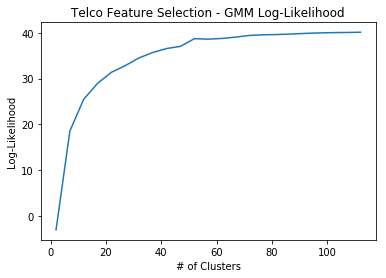

<Figure size 864x864 with 0 Axes>

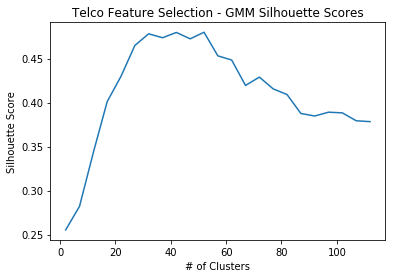

<Figure size 864x864 with 0 Axes>

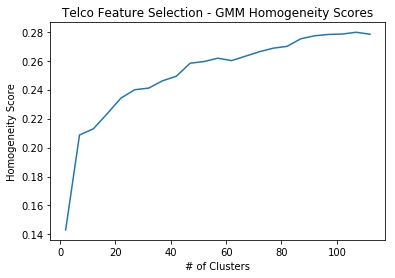

<Figure size 864x864 with 0 Axes>

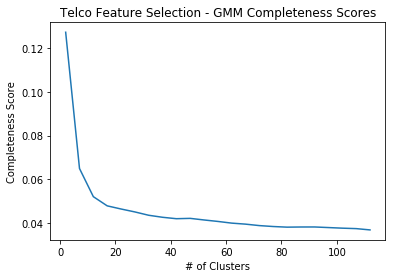

<Figure size 864x864 with 0 Axes>

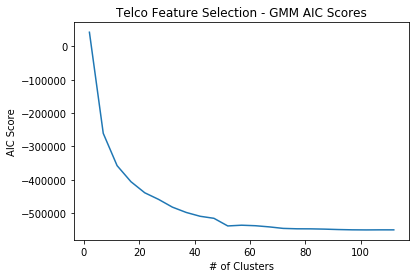

<Figure size 864x864 with 0 Axes>

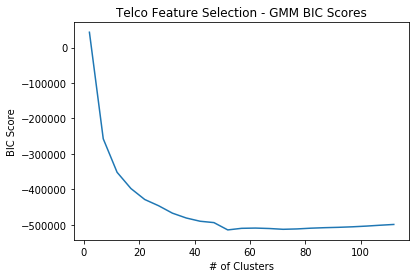

<Figure size 864x864 with 0 Axes>

In [111]:
plot_curve('Telco Feature Selection - GMM Log-Likelihood', '# of Clusters', 'Log-Likelihood', fs_gmm_x, fs_gmm_log_likelihood)
plot_curve('Telco Feature Selection - GMM Silhouette Scores', '# of Clusters', 'Silhouette Score', fs_gmm_x, fs_gmm_silhouette_scores)
plot_curve('Telco Feature Selection - GMM Homogeneity Scores', '# of Clusters', 'Homogeneity Score', fs_gmm_x, fs_gmm_homogeneity_scores)
plot_curve('Telco Feature Selection - GMM Completeness Scores', '# of Clusters', 'Completeness Score', fs_gmm_x, fs_gmm_completeness_scores)
plot_curve('Telco Feature Selection - GMM AIC Scores', '# of Clusters', 'AIC Score', fs_gmm_x, fs_gmm_aic_scores)
plot_curve('Telco Feature Selection - GMM BIC Scores', '# of Clusters', 'BIC Score', fs_gmm_x, fs_gmm_bic_scores)

# Neural Network Performance

In [140]:
clf = MLPClassifier(solver='adam', alpha=1.0, activation='relu', batch_size=20,
            learning_rate='constant', random_state=RANDOM_STATE,
            hidden_layer_sizes=(30), max_iter=10)
clf = clf.fit(X, y)
benchmark_acc = cross_val_score(clf, X, y, cv=4).mean()

/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

### Dimensionality Reduction

In [121]:
max_components = X.shape[1]

nn_x_range = []

pca_nn_acc = []
ica_nn_acc = []
rand_nn_acc = []
fs_nn_acc = []

for i in range(1, max_components + 1, 3):
    print(i)
    nn_x_range.append(i)
    
    pca = PCA(n_components=i, random_state=RANDOM_STATE).fit(X)
    X_pca = pca.transform(X)
    
    ica = FastICA(n_components=i, random_state=RANDOM_STATE).fit(X)
    X_ica = ica.transform(X)
    
    grp = GaussianRandomProjection(n_components=i, random_state=RANDOM_STATE).fit(X)
    X_rand = grp.transform(X)
    
    rfc = RandomForestClassifier(max_depth=4, n_estimators=20)
    feature_selector = ImportanceSelector(rfc, n=i)
    feature_selector = feature_selector.fit(X, y)
    X_fs = feature_selector.transform(X)

    clf = MLPClassifier(solver='adam', alpha=1.0, activation='relu', batch_size=20,
                learning_rate='constant', random_state=RANDOM_STATE,
                hidden_layer_sizes=(30), max_iter=10)

    pca_nn_acc.append(cross_val_score(clf, X_pca, y, cv=4).mean())
    ica_nn_acc.append(cross_val_score(clf, X_ica, y, cv=4).mean())
    rand_nn_acc.append(cross_val_score(clf, X_rand, y, cv=4).mean())
    fs_nn_acc.append(cross_val_score(clf, X_fs, y, cv=4).mean())

1


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

4


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

7


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

10


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

13


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

16


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

19


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

22


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Opti

25


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Opti

28


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Opti

31


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Opti

34


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Opti

37


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Opti

40


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Opti

43


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Opti

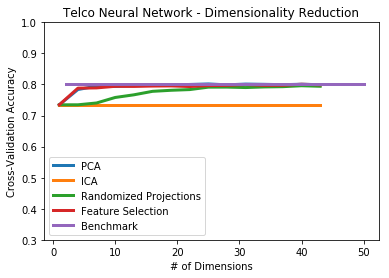

<Figure size 864x864 with 0 Axes>

In [144]:
plt.plot(nn_x_range, pca_nn_acc, linewidth=3, label='PCA')
plt.plot(nn_x_range, ica_nn_acc, linewidth=3, label='ICA')
plt.plot(nn_x_range, rand_nn_acc, linewidth=3, label='Randomized Projections')
plt.plot(nn_x_range, fs_nn_acc, linewidth=3, label='Feature Selection')
plt.plot(cluster_x_range, [benchmark_acc] * len(cluster_x_range), linewidth=3, label='Benchmark')
plt.legend()
plt.title('Telco Neural Network - Dimensionality Reduction')
plt.ylim(0.3, 1.0)
plt.xlabel('# of Dimensions')
plt.ylabel('Cross-Validation Accuracy')
plt.figure(figsize=(12,12))
plt.show()

## Dimensionality Reduction and Clustering

In [127]:
def augment_dataset_with_clusters(X, k):
    # K-means
    km = MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE).fit(X)
    km_labels = km.labels_.reshape(-1, 1)
    
    enc = OneHotEncoder()
    enc = enc.fit(km_labels)
    km_onehot = enc.transform(km_labels).todense()
    
    # GMM
    gmm = GaussianMixture(n_components=k, random_state=RANDOM_STATE).fit(X)
    gmm_proba = gmm.predict_proba(X)

    return np.hstack((km_onehot, gmm_proba))

In [137]:
max_k = 50

train_acc = []
test_acc = []
cluster_x_range = []

cluster_pca_nn_acc = []
cluster_ica_nn_acc = []
cluster_rand_nn_acc = []
cluster_fs_nn_acc = []

for i in range(2, max_k + 1, 4):
    print(i)
    cluster_x_range.append(i)
    
    pca = PCA(n_components=8, random_state=RANDOM_STATE).fit(X)
    X_pca = pca.transform(X)
    X_pca = augment_dataset_with_clusters(X_pca, i)
    
    ica = FastICA(n_components=8, random_state=RANDOM_STATE).fit(X)
    X_ica = ica.transform(X)
    X_ica = augment_dataset_with_clusters(X_ica, i)
    
    grp = GaussianRandomProjection(n_components=20, random_state=RANDOM_STATE).fit(X)
    X_rand = grp.transform(X)
    X_rand = augment_dataset_with_clusters(X_rand, i)
    
    rfc = RandomForestClassifier(max_depth=4, n_estimators=20)
    feature_selector = ImportanceSelector(rfc, n=8)
    feature_selector = feature_selector.fit(X, y)
    X_fs = feature_selector.transform(X)
    X_fs = augment_dataset_with_clusters(X_fs, i)
    
    clf = MLPClassifier(solver='adam', alpha=1.0, activation='relu', batch_size=20,
                learning_rate='constant', random_state=RANDOM_STATE,
                hidden_layer_sizes=(40, 40), max_iter=12)

    cluster_pca_nn_acc.append(cross_val_score(clf, X_pca, y, cv=5).mean())
    cluster_ica_nn_acc.append(cross_val_score(clf, X_ica, y, cv=5).mean())
    cluster_rand_nn_acc.append(cross_val_score(clf, X_rand, y, cv=5).mean())
    cluster_fs_nn_acc.append(cross_val_score(clf, X_fs, y, cv=5).mean())

2


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

6


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

10


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

14


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

18


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

22


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

26


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

30


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

34


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

38


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

42


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

46


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

50


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

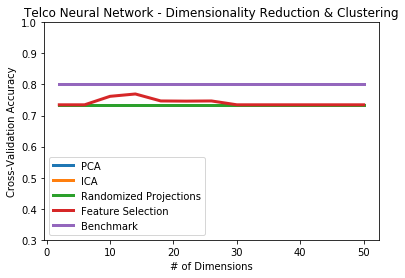

<Figure size 864x864 with 0 Axes>

In [143]:
plt.plot(cluster_x_range, cluster_pca_nn_acc, linewidth=3, label='PCA')
plt.plot(cluster_x_range, cluster_ica_nn_acc, linewidth=3, label='ICA')
plt.plot(cluster_x_range, cluster_rand_nn_acc, linewidth=3, label='Randomized Projections')
plt.plot(cluster_x_range, cluster_fs_nn_acc, linewidth=3, label='Feature Selection')
plt.plot(cluster_x_range, [benchmark_acc] * len(cluster_x_range), linewidth=3, label='Benchmark')
plt.title('Telco Neural Network - Dimensionality Reduction & Clustering')
plt.legend()
plt.ylim(0.3, 1.0)
plt.xlabel('# of Dimensions')
plt.ylabel('Cross-Validation Accuracy')
plt.figure(figsize=(12,12))
plt.show()

In [141]:
benchmark_acc

0.8012210269539152